In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply
from keras.layers import concatenate, core, Dropout
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K

Using TensorFlow backend.


In [0]:
# Function to convert image from greyscale to one hot (i.e. 3 channels)
def convertToOneHot(image):
    num_classes = 3
    shape = image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c]==0:
          encoded_image[r][c][0] = 1
        elif image[r][c]==128:
          encoded_image[r][c][1] = 1
        else:
          encoded_image[r][c][2] = 1
    return encoded_image

In [0]:
# Function to convert back from one hot image to greyscale
def convertFromOneHot(image):
    shape = image.shape[:2]
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c][0] == 1:
          encoded_image[r][c] = 0
        elif image[r][c][1] == 1:
          encoded_image[r][c] = 128
        else:
          encoded_image[r][c] = 255
    return encoded_image

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays"

# Train set paitients: 230 232
TrainX_1 = np.load(PATH + '/ER IHC 239 Images.npy')
TrainY_1 = np.load(PATH + '/ER IHC 239 Masks.npy')
TrainX_2 = np.load(PATH + '/ER IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/ER IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/ER IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/ER IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/ER IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/ER IHC 230 Masks.npy')

# Test set paitients: 221 239 242 246
TestX_1 = np.load(PATH + '/ER IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/ER IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/ER IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/ER IHC 246 Masks.npy')


In [7]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGroundTruth = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = []

for img in TrainGroundTruth:
  encoded_img = convertToOneHot(img)
  TrainY.append(encoded_img)

TrainY = np.asarray(TrainY)

TestX = np.concatenate((TestX_1, TestX_2), axis=0)
TestGroundTruth = np.concatenate((TestY_1, TestY_2), axis=0)
TestY = []

for img in TestGroundTruth:
  encoded_img = convertToOneHot(img)
  TestY.append(encoded_img)

TestY = np.asarray(TestY)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 3)
(960, 240, 240, 3)
(960, 240, 240, 3)
(120, 240, 240, 3)
(120, 240, 240, 3)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,3))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,3))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,3))

ValidX = ValidX.astype('float32')/255

In [9]:
TrainX = np.rollaxis(TrainX, 3, 1)  ;
TrainY = np.rollaxis(TrainY, 3 ,1)  ; 
ValidX = np.rollaxis(ValidX, 3, 1)  ;
ValidY = np.rollaxis(ValidY, 3, 1)  ;
TestX = np.rollaxis(TestX, 3, 1)   ;
TestY = np.rollaxis(TestY, 3, 1)  ;
print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)


(1800, 3, 240, 240)
(1800, 3, 240, 240)
(960, 3, 240, 240)
(960, 3, 240, 240)
(120, 3, 240, 240)
(120, 3, 240, 240)


In [9]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model

In [0]:
def up_and_concate(down_layer, layer, data_format='channels_last'):
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])

    return concate


def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate


def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x


def res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

              padding='same', data_format='channels_last'):
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    layer = input_layer
    for i in range(2):
        layer = Conv2D(out_n_filters // 4, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)
        if batch_normalization:
            layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        layer = Conv2D(out_n_filters // 4, kernel_size, strides=stride, padding=padding, data_format=data_format)(layer)
        layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer
    out_layer = add([layer, skip_layer])
    return out_layer


# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

                  padding='same', data_format='channels_last'):
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer

    layer = skip_layer
    for j in range(2):

        for i in range(2):
            if i == 0:

                layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(
                    layer)
                if batch_normalization:
                    layer1 = BatchNormalization()(layer1)
                layer1 = Activation('relu')(layer1)
            layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(
                add([layer1, layer]))
            if batch_normalization:
                layer1 = BatchNormalization()(layer1)
            layer1 = Activation('relu')(layer1)
        layer = layer1

    out_layer = add([layer, skip_layer])
    return out_layer



########################################################################################################
#Attention R2U-Net
def att_r2_unet(img_w, img_h, n_label, data_format='channels_last'):
    inputs = Input((img_w, img_h, 3))
    x = inputs
    depth = 4
    features = 32
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)

        features = features * 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = core.Activation('softmax')(conv6)
    model = Model(inputs=inputs, outputs=conv7)
    #model.compile(optimizer=Adam(lr=1e-6), loss=[dice_coef_loss], metrics=['accuracy', dice_coef])
    return model

In [11]:
model = att_r2_unet(240,240,3)
model.summary()






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 240, 240, 32) 0           conv2d_2[0][0]                   
_______________________________________________________________________________________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(0.5*tversky_loss(y_true, y_pred))

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [15]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer=optimizer, metrics=[dice_coef,'accuracy'])

In [16]:
num_epoch = 100;
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
history = model.fit(TrainX, TrainY, epochs=num_epoch, validation_data=(ValidX, ValidY), shuffle=True,batch_size=16,callbacks=[es,mc])
model.save(MODELS_PATH + '/UNET_ER_R2Unet_20_02_22_v1.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1800 samples, validate on 120 samples
Epoch 1/100





1800/1800 [==============================] - 60s 33ms/step - loss: 3.2392 - dice_coef: 0.8615 - acc: 0.8615 - val_loss: nan - val_dice_coef: 0.9885 - val_acc: 0.9885

Epoch 00001: val_loss did not improve from inf
Epoch 2/100
1800/1800 [==============================] - 51s 28ms/step - loss: 3.1544 - dice_coef: 0.8685 - acc: 0.8685 - val_loss: nan - val_dice_coef: 0.9885 - val_acc: 0.9885

Epoch 00002: val_loss did not improve from inf
Epoch 3/100
1800/1800 [==============================] - 51s 28ms/step - loss: 3.1544 - dice_coef: 0.8685 - acc: 0.8685 - val_loss: nan - val_dice_coef: 0.9885 - val_acc: 0.9885

Epoch 00003: val_loss did not improve from inf
Epoch 4/100
1800/1800 [==============================] - 51s 28ms/step - loss: 3.1544 - dice_coef: 0.8685 - acc: 0.8685 - val_loss: nan - val_dice_coef: 0.9885 - val_acc: 0.

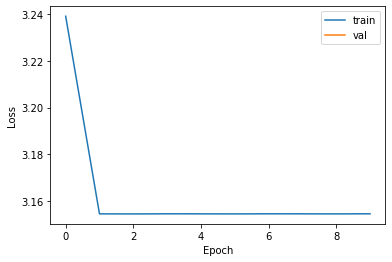

In [17]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result    

In [19]:
train_result = model.predict(TrainX, batch_size=16)
print(np.shape(train_result))
Train_predict = [ ]
for img in train_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_predict.append(encoded_img)

Predicted_images = np.asarray(Train_predict)
print(Predicted_images.shape)
np.unique(Predicted_images)

(1800, 240, 240, 3)
(1800, 240, 240)


array([0], dtype=uint8)

In [20]:
test_result = model.predict(TestX, batch_size=16)
print(np.shape(test_result))

Test_predict = [ ]
for img in test_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_predict.append(encoded_img)

Predicted_images_test = np.asarray(Test_predict)
print(Predicted_images_test.shape)
np.unique(Predicted_images_test)

(960, 240, 240, 3)
(960, 240, 240)


array([0], dtype=uint8)

In [0]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(Actual, Predicted):
  ActualY = np.reshape(Actual,(-1, Actual.shape[3]))
  PredY = np.reshape(Predicted,(-1, Predicted.shape[3]))
  matrix = confusion_matrix(ActualY.argmax(axis = 1), PredY.argmax(axis = 1))
  return matrix

def get_precision(confusion_matrix):
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  nan_indices = np.isnan(precision)
  precision[nan_indices] = 0
  return precision

def get_recall(confusion_matrix):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  nan_indices = np.isnan(recall)
  recall[nan_indices] = 0
  return recall


In [22]:
test_matrix = get_confusion_matrix(TestY, test_result)
train_matrix = get_confusion_matrix(TrainY, train_result)
print(test_matrix)
print(train_matrix)

[[55268692        0]
 [   27308        0]]
[[90049443        0        0]
 [ 6145815        0        0]
 [ 7484742        0        0]]


In [23]:
test_precision = get_precision(test_matrix)
print('Test Precision')
print(test_precision)
test_recall = get_recall(test_matrix)
print('Test Recall')
print(test_recall)
train_precision = get_precision(train_matrix)
print('Train Precision')
print(train_precision)
train_recall = get_recall(train_matrix)
print('Train Recall')
print(train_recall)

Test Precision
[0.99950615 0.        ]
Test Recall
[1. 0.]
Train Precision
[0.86853244 0.         0.        ]
Train Recall
[1. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [24]:
weight_matrix = np.zeros((3,1))
weight_matrix[0] = 1/3
weight_matrix[1] = 1/3
weight_matrix[2] = 1/3
print(weight_matrix.shape)

(3, 1)


In [0]:
def get_overall_precision(precision, weights):
  final_precision = np.dot(precision,weights)
  return final_precision

def get_overall_recall(recall, weights):
  final_recall = np.dot(recall ,weights)
  return final_recall

In [26]:
final_test_precision  = get_overall_precision(test_precision, weight_matrix)
final_test_recall     = get_overall_recall(test_recall, weight_matrix)
final_train_precision = get_overall_precision(train_precision, weight_matrix)
final_train_recall    = get_overall_recall(train_recall, weight_matrix)
print('Final Test Precision')
print(final_test_precision)
print('Final Test Recall')
print(final_test_recall)
print('Final Train Precision')
print(final_train_precision)
print('Final Train Recall')
print(final_train_recall)

ValueError: ignored

In [0]:
from scipy.stats import hmean

def dice_coefficient(precision, recall):
  return hmean(np.asarray([precision , recall]))

In [0]:
test_dice_coeff = dice_coefficient(final_test_precision, final_test_recall)
print('Test Dice coeff')
print(test_dice_coeff)

train_dice_coeff = dice_coefficient(final_train_precision, final_train_recall)
print('Train Dice coeff')
print(train_dice_coeff)

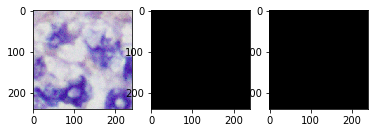

In [27]:
copy1  = np.copy(TestX [250])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[250]

Predicted_Mask = Predicted_images_test[250] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img

In [0]:
def saveNumpyOutput(mask):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id, id+10):
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/Combined_Loss/ER1 Patient " + str(id), final_output)

(48, 240, 240, 3)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[0.]


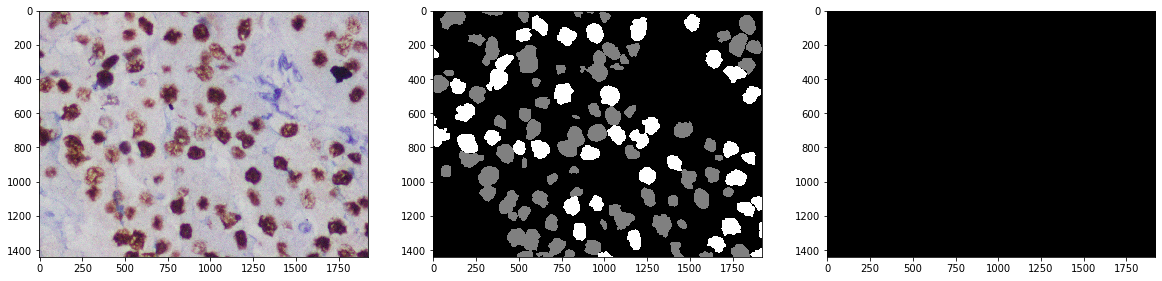

In [29]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 14  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')
